# SVM с мягким зазором (soft-margin SVM)

## Подрубаем библиотеки

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def newline(p1, p2, color=None): # функция отрисовки линии
    #function kredits to: https://fooobar.com/questions/626491/how-to-draw-a-line-with-matplotlib
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

## Алгоритм

Здесь и далее w*x = w1 * x1  +  w2 * x2  +  ...  +  wn * 1

- margin = y(w*x) --> max
- уравнение полосы разделения: -1<w*x<1 
- Hinge_loss = 0.5w*w+max(1-y(w*x),0) --> min

hard-margin:
 - никакие объекты из трейновой выборки не должны попадать на полосу разделения. Покажем работу алгоритма на датасете Ирис, для классов 0 и 1+2
 
soft-margin:
 - позволим алгоритму допускать ошибки на обучающих объектах, но при этом постараемся, чтобы ошибок было поменьше. Покажем работу алгоритма на датасете Ирис, для классов 0+1 и 2

Правила изменения весов вытекают из минимизации функционала Q=max(1-margin,0)+alpha*w^2:
 - w = w - C * w (правильная классификация, ywx > 1)
 - w = w - step*(y * x  -  C * w) (неправильная классификация, ywx < 0 << 1 или объект попал на полосу, 0<ywx<1)

In [2]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended


class CustomSVM(object):
    
    __class__ = "CustomSVM"
    __doc__ = """
    This is an implementation of the SVM classification algorithm
    Note that it works only for binary classification
    
    #############################################################
    ######################   PARAMETERS    ######################
    #############################################################
    
    etha: float(default - 0.01)
        Learning rate, gradient step
        
    alpha: float, (default - 1.0)
        Regularization parameter in 0.5*alpha*||w||^2
        
    epochs: int, (default - 200)
        Number of epochs of training
      
    #############################################################
    #############################################################
    #############################################################
    """
    
    def __init__(self, etha=0.01, alpha=0.1, epochs=200):
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None
    

    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1
        
        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")
        
        X_train = add_bias_feature(X_train)
        X_val = add_bias_feature(X_val)
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []
        
        for epoch in range(self._epochs): 
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train):
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                if margin >= 1: # классифицируем верно
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                else: # классифицируем неверно или попадаем на полосу разделения при 0<m<1
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._alpha*self._w/self._epochs)
                    tr_err += 1
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                self.history_w.append(self._w)
            for i,x in enumerate(X_val):
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'\
                      .format(epoch,err,loss))
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
        self.history_w = np.array(self.history_w)    
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)                    
            

    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)         
    
    
    def hinge_loss(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))
    
    
    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x,y)+self._alpha*np.dot(self._w, self._w)

## Демонстрируем, что работает для линейно разделимой выборки:

In [3]:
# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)*2-1 # [0,1,2] --> [False,True,True] --> [0,1,1] --> [0,2,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[64 33 25 19 14 14 12 10  9  7  6  5  6  5  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  3  3  3  3  2  2  3  1  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  1  2  1
  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
  2  1  2  1  1  2  1  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[ 0.95283273 -0.87457071  1.20880038]


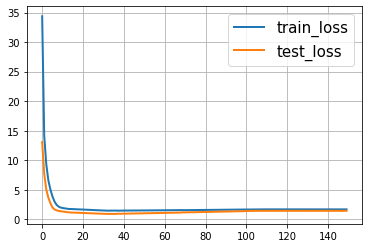

In [4]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.005, alpha=0.006, epochs=150)
svm.fit(X_train, Y_train, X_test, Y_test)


print(svm.train_errors) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

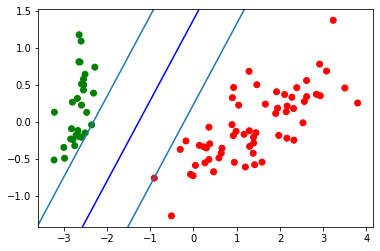

In [5]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

#### Убеждаемся, что все объекты из отложенной выборки классифицируются правильно

Количество ошибок для отложенной выборки:  0


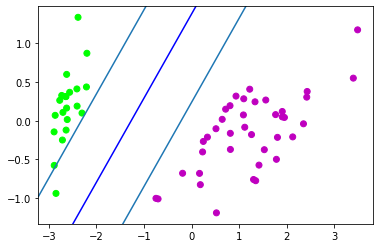

In [6]:
# предсказываем после обучения
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Количество ошибок для отложенной выборки: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

## Демонстрируем, что работает для линейно неразделимой выборки:

In [7]:
# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y == 2).astype(int)*2-1 # [0,1,2] --> [False,False,True] --> [0,1,1] --> [0,0,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[49 40 35 31 28 25 25 25 25 24 24 23 23 24 23 22 22 22 22 20 20 17 17 17
 17 17 19 18 17 17 17 17 17 17 17 15 17 15 15 15 14 15 15 15 15 14 15 15
 15 14 15 15 15 14 15 15 15 12 15 15 13 12 15 12 13 12 13 12 13 12 13 12
 13 12 13 12 13 12 13 12 13 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11
 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11
 12 11 12 11 11 12 11 12 11 12 11 12 10 11 12 10 11 12 10 11 10 10 10 11
 10 10 10 11 10 10]
[ 4.35689143 -2.24709139 -5.61348076]


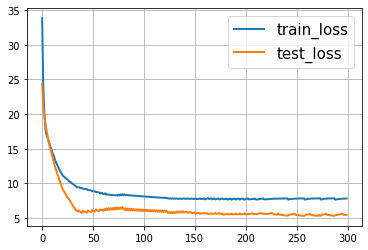

In [8]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.03, alpha=0.0001, epochs=300)
svm.fit(X_train, Y_train, X_test, Y_test)


print(svm.train_errors[:150]) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

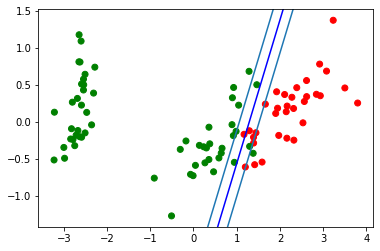

In [9]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

Количество ошибок для отложенной выборки:  2


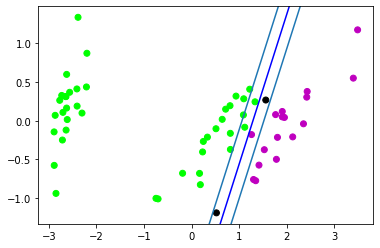

In [10]:
# предсказываем после обучения
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Количество ошибок для отложенной выборки: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

# Loss functions

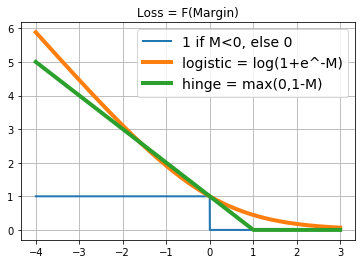

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xx = np.linspace(-4,3,100000)
plt.plot(xx, [(x<0).astype(int) for x in xx], linewidth=2, label='1 if M<0, else 0')
plt.plot(xx, [np.log2(1+2.76**(-x))  for x in xx], linewidth=4, label='logistic = log(1+e^-M)')
plt.plot(xx, [np.max(np.array([0,1-x]))  for x in xx], linewidth=4, label='hinge = max(0,1-M)')
plt.title('Loss = F(Margin)')
plt.grid()
plt.legend(prop={'size': 14});

# Делаем анимацию обучения

In [14]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter


def one_image(w, X, Y):
    axes = plt.gca()
    axes.set_xlim([-4,4])
    axes.set_ylim([-1.5,1.5])
    d1 = {-1:'green', 1:'red'}
    im = plt.scatter(X[:,0], X[:,1], c=[d1[y] for y in Y])
    im = newline([0,-w[2]/w[1]],[-w[2]/w[0],0], 'blue')
#    im = newline([0,1/w[1]-w[2]/w[1]],[1/w[0]-w[2]/w[0],0], 'lime') #w0*x_i[0]+w1*x_i[1]+w2*1=1
#    im = newline([0,-1/w[1]-w[2]/w[1]],[-1/w[0]-w[2]/w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
    return im

[ 0.01869039 -0.02226957 -0.06593326]


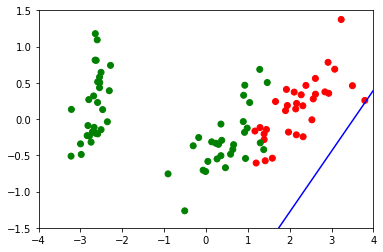

In [15]:
print(svm.history_w[0])
im = one_image(svm.history_w[0], X_train, Y_train)

In [16]:
svm.history_w.shape

(27001, 3)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


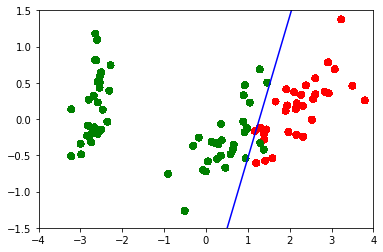

In [15]:
fig = plt.figure()

ims = []
for i in range(500):
    if i<=300:
        k = i
    else:
        k = (i-298)*130
    im = one_image(svm.history_w[k], X_train, Y_train)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True,
                                repeat_delay=500)

writer = PillowWriter(fps=20)
ani.save("my_demo.gif", writer='imagemagick')
#plt.show()

# Из коробки

In [17]:
from sklearn import svm
from sklearn.metrics import recall_score

C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C)
#model1 = svm.LinearSVC(C=C, max_iter=10000)
#model1 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#model1 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)

model1.fit(X_train, Y_train)
y_predict = model1.predict(X_test)
print(recall_score(Y_test, y_predict, average=None))

[0.97619048 0.94444444]
